### Сформулированные гипотезы

1.  **Гипотеза 1 (Влияние тяжести погодных явлений):** Чем выше "Severity" (серьезность) погодного явления, тем выше вероятность задержек или отмен рейсов, а также больше средняя длительность задержки.
2.  **Гипотеза 2 (Влияние типа погодного явления):** Определенные типы погодных явлений (например, "Snow", "Fog", "Heavy Rain") оказывают значительно большее влияние на "DEP_DELAY" (задержку вылета) и "CANCELLED" (отмененные рейсы) по сравнению с другими типами.
3.  **Гипотеза 3 (Влияние продолжительности погодного явления):** Более длительные погодные явления ("EndTime(UTC)" - "StartTime(UTC)") в районе аэропорта коррелируют с увеличением количества отмененных рейсов и средних задержек в аэропорту.

## Сопоставление и агрегация данных

In [ ]:
import os
import pandas as pd
import kagglehub
import pytz

# Re-load the us_weather_df as it was not defined
us_weather_events_path = kagglehub.dataset_download("sobhanmoosavi/us-weather-events")
us_weather_df = pd.read_csv(os.path.abspath(os.path.join(os.getcwd(),
                                                      us_weather_events_path,
                                                      'WeatherEvents_Jan2016-Dec2022.csv')))

# Convert StartTime(UTC) and EndTime(UTC) to datetime objects
us_weather_df['StartTime(UTC)'] = pd.to_datetime(us_weather_df['StartTime(UTC)'])
us_weather_df['EndTime(UTC)'] = pd.to_datetime(us_weather_df['EndTime(UTC)'])

# 1. Определите числовое отображение для столбца Severity
severity_mapping = {'Minor': 1, 'Moderate': 2, 'Severe': 3, 'Extreme': 4}
us_weather_df['Severity_Num'] = us_weather_df['Severity'].map(severity_mapping)

# 2. Вычислите продолжительность каждого погодного явления в часах
us_weather_df['Duration_Hours'] = (us_weather_df['EndTime(UTC)'] - us_weather_df['StartTime(UTC)']).dt.total_seconds() / 3600

# 3. Преобразуйте время UTC в локальные даты на основе часового пояса
def convert_utc_to_local(row):
    if pd.isna(row['StartTime(UTC)']):
        return pd.NaT # If start time is NaT, local time is also NaT
    try:
        utc_time = row['StartTime(UTC)'].tz_localize('UTC')
        local_tz = pytz.timezone(row['TimeZone'])
        return utc_time.tz_convert(local_tz)
    except Exception:
        return pd.NaT # Handle potential errors with timezone conversion

us_weather_df['Local_Start_Time'] = us_weather_df.apply(convert_utc_to_local, axis=1)
# Ensure 'Local_Start_Time' is a datetime type before accessing .dt accessor
us_weather_df['Local_Start_Time'] = pd.to_datetime(us_weather_df['Local_Start_Time'], errors='coerce')
us_weather_df['Local_Date'] = us_weather_df['Local_Start_Time'].dt.date

# 4. Создайте логические флаги для конкретных типов погоды
# Significant weather types identified from initial data exploration or domain knowledge
significant_weather_types = ['Snow', 'Fog', 'Heavy Rain', 'Thunderstorm', 'Rain', 'Light Rain', 'Sleet', 'Freezing Rain', 'Wintry Mix']

for weather_type in significant_weather_types:
    col_name = f'Is_{weather_type.replace(" ", "")}'
    us_weather_df[col_name] = us_weather_df['Type'].apply(lambda x: weather_type in x.split(', ') if pd.notna(x) else False)

print("Created 'Severity_Num', 'Duration_Hours', 'Local_Start_Time', 'Local_Date' and weather type flags in us_weather_df.")
print(us_weather_df[['EventId', 'Severity', 'Severity_Num', 'StartTime(UTC)', 'EndTime(UTC)', 'Duration_Hours', 'TimeZone', 'Local_Start_Time', 'Local_Date', 'Type', 'Is_Snow', 'Is_Fog']].head())

In [3]:
aggregated_weather_df = us_weather_df.groupby(['AirportCode', 'Local_Date']).agg(
    Max_Severity=('Severity_Num', 'max'),
    Total_Duration_Hours=('Duration_Hours', 'sum'),
    Num_Weather_Events=('EventId', 'count'),
    Is_Snow=('Is_Snow', 'any'),
    Is_Fog=('Is_Fog', 'any'),
    Is_HeavyRain=('Is_HeavyRain', 'any'),
    Is_Thunderstorm=('Is_Thunderstorm', 'any'),
    Is_Rain=('Is_Rain', 'any'),
    Is_LightRain=('Is_LightRain', 'any'),
    Is_Sleet=('Is_Sleet', 'any'),
    Is_FreezingRain=('Is_FreezingRain', 'any'),
    Is_WintryMix=('Is_WintryMix', 'any')
).reset_index()

print("Aggregated weather data by AirportCode and Local_Date:")
print(aggregated_weather_df.head())

Aggregated weather data by AirportCode and Local_Date:
  AirportCode  Local_Date  Max_Severity  Total_Duration_Hours  \
0        K04V  2016-01-06           NaN             11.666667   
1        K04V  2016-01-07           NaN              0.333333   
2        K04V  2016-01-08           NaN              3.333333   
3        K04V  2016-01-09           3.0              9.000000   
4        K04V  2016-01-10           3.0             11.666667   

   Num_Weather_Events  Is_Snow  Is_Fog  Is_HeavyRain  Is_Thunderstorm  \
0                   3     True   False         False            False   
1                   1     True   False         False            False   
2                   2     True   False         False            False   
3                   6     True    True         False            False   
4                   5     True    True         False            False   

   Is_Rain  Is_LightRain  Is_Sleet  Is_FreezingRain  Is_WintryMix  
0    False         False     False            F

In [ ]:
import os
import pandas as pd
import kagglehub

# Re-load flight_delays as it was not defined
path = kagglehub.dataset_download("patrickzel/flight-delay-and-cancellation-dataset-2019-2023")
flight_delays = pd.read_csv(os.path.abspath(os.path.join(os.getcwd(),
                                                      path,
                                                      'flights_sample_3m.csv')))

# Convert 'FL_DATE' to datetime objects in flight_delays (re-applying previous successful step)
flight_delays['FL_DATE'] = pd.to_datetime(flight_delays['FL_DATE'])

# Correctly use 'ORIGIN' and 'DEST' column names as identified from previous output
unique_origin_airports = flight_delays['ORIGIN'].unique()
unique_dest_airports = flight_delays['DEST'].unique()

# Combine and find all unique airport IDs
all_unique_flight_airports = pd.unique(list(unique_origin_airports) + list(unique_dest_airports))

print(f"Total unique origin airports: {len(unique_origin_airports)}")
print(f"Total unique destination airports: {len(unique_dest_airports)}")
print(f"Total unique airports in flight data: {len(all_unique_flight_airports)}")

In [7]:
aggregated_flight_df = flight_delays.groupby(['ORIGIN', 'FL_DATE']).agg(
    Total_Flights=('FL_NUMBER', 'count'),
    Total_Cancelled_Flights=('CANCELLED', lambda x: (x == 1).sum()),
    Average_Dep_Delay=('DEP_DELAY', 'mean'),
    Total_Weather_Delays=('DELAY_DUE_WEATHER', lambda x: (x == 1).sum())
).reset_index()

print("Aggregated flight data by Origin Airport and Flight Date:")
print(aggregated_flight_df.head())

Aggregated flight data by Origin Airport and Flight Date:
  ORIGIN    FL_DATE  Total_Flights  Total_Cancelled_Flights  \
0    ABE 2019-01-02              2                        0   
1    ABE 2019-01-03              1                        0   
2    ABE 2019-01-04              1                        0   
3    ABE 2019-01-05              2                        0   
4    ABE 2019-01-07              1                        0   

   Average_Dep_Delay  Total_Weather_Delays  
0              -12.0                     0  
1                8.0                     0  
2                7.0                     0  
3               -2.0                     0  
4               -4.0                     0  


## Соединение таблиц погоды и задержек рейсов

In [ ]:
import pandas as pd

# Check airport code lengths in aggregated_weather_df
print("AirportCode length distribution in aggregated_weather_df:")
print(aggregated_weather_df['AirportCode'].str.len().value_counts())

# Check airport code lengths in aggregated_flight_df (ORIGIN column)
print("\nORIGIN airport code length distribution in aggregated_flight_df:")
print(aggregated_flight_df['ORIGIN'].str.len().value_counts())

# Check a sample of codes from both dataframes
print("\nSample AirportCodes from aggregated_weather_df:")
print(aggregated_weather_df['AirportCode'].head())

print("\nSample ORIGIN codes from aggregated_flight_df:")
print(aggregated_flight_df['ORIGIN'].head())

s
### Сопоставление ключей

- `aggregated_weather_df` имеет 4-значный код для аэропорта (e.g., 'K04V', 'KNYC'), которые являются ICAO кодами.
- `aggregated_flight_df` -- 3-х значный (e.g., 'ABE', 'ATL'), это IATA коды.

In [1]:
import pandas as pd

icao_iata_data = {
    'icao_code': ['KABE', 'KPHX', 'KSEA', 'KJFK', 'KLGA', 'KORD', 'KATL', 'KLAX', 'KDEN', 'KDCA', 'KBOS'],
    'iata_code': ['ABE', 'PHX', 'SEA', 'JFK', 'LGA', 'ORD', 'ATL', 'LAX', 'DEN', 'DCA', 'BOS']
}
icao_iata_mapping = pd.DataFrame(icao_iata_data)
icao_iata_mapping.loc[len(icao_iata_mapping)] = ['K04V', '04V'] # '04V' is a hypothetical IATA for K04V
print(icao_iata_mapping.head())

  icao_code iata_code
0      KABE       ABE
1      KPHX       PHX
2      KSEA       SEA
3      KJFK       JFK
4      KLGA       LGA


In [15]:
import pandas as pd

aggregated_weather_df = us_weather_df.groupby(['AirportCode', 'Local_Date']).agg(
    Max_Severity=('Severity_Num', 'max'),
    Total_Duration_Hours=('Duration_Hours', 'sum'),
    Num_Weather_Events=('EventId', 'count'),
    Is_Snow=('Is_Snow', 'any'),
    Is_Fog=('Is_Fog', 'any'),
    Is_HeavyRain=('Is_HeavyRain', 'any'),
    Is_Thunderstorm=('Is_Thunderstorm', 'any'),
    Is_Rain=('Is_Rain', 'any'),
    Is_LightRain=('Is_LightRain', 'any'),
    Is_Sleet=('Is_Sleet', 'any'),
    Is_FreezingRain=('Is_FreezingRain', 'any'),
    Is_WintryMix=('Is_WintryMix', 'any')
).reset_index()

# Merge the freshly aggregated_weather_df with the ICAO-IATA mapping
aggregated_weather_df = pd.merge(
    aggregated_weather_df,
    icao_iata_mapping,
    left_on='AirportCode',
    right_on='icao_code',
    how='left'
)

# Create a temporary column for the new IATA codes, falling back to original ICAO if no mapping
aggregated_weather_df['AirportCode_IATA_Temp'] = aggregated_weather_df['iata_code'].fillna(aggregated_weather_df['AirportCode'])

# Drop the intermediate 'icao_code' and 'iata_code' columns
aggregated_weather_df.drop(columns=['AirportCode', 'icao_code', 'iata_code'], inplace=True)
aggregated_weather_df.rename(columns={'AirportCode_IATA_Temp': 'AirportCode'}, inplace=True)

print(aggregated_weather_df[['AirportCode', 'Local_Date', 'Max_Severity']].head())

print("\nNew AirportCode length distribution in aggregated_weather_df:")
print(aggregated_weather_df['AirportCode'].str.len().value_counts())

Converted 'AirportCode' in aggregated_weather_df from ICAO to IATA codes where mapping was found.
Sample of aggregated_weather_df with updated AirportCodes:
  AirportCode  Local_Date  Max_Severity
0         04V  2016-01-06           NaN
1         04V  2016-01-07           NaN
2         04V  2016-01-08           NaN
3         04V  2016-01-09           3.0
4         04V  2016-01-10           3.0

New AirportCode length distribution in aggregated_weather_df:
AirportCode
4    256643
3      2024
Name: count, dtype: int64


In [16]:
import pandas as pd

aggregated_flight_df['FL_DATE'] = aggregated_flight_df['FL_DATE'].dt.date
aggregated_flight_df['ORIGIN'] = aggregated_flight_df['ORIGIN'].astype(str)
aggregated_weather_df['AirportCode'] = aggregated_weather_df['AirportCode'].astype(str)

# Merge the dataframes
merged_df = pd.merge(
    aggregated_flight_df,
    aggregated_weather_df,
    left_on=['ORIGIN', 'FL_DATE'],
    right_on=['AirportCode', 'Local_Date'],
    how='left'
)

# Drop the redundant 'AirportCode' and 'Local_Date' columns from the merged dataframe
merged_df.drop(columns=['AirportCode', 'Local_Date'], inplace=True)

print("Merged flight and weather data after ICAO-IATA conversion. Displaying first 5 rows:")
print(merged_df.head())

Merged flight and weather data after ICAO-IATA conversion. Displaying first 5 rows:
  ORIGIN     FL_DATE  Total_Flights  Total_Cancelled_Flights  \
0    ABE  2019-01-02              2                        0   
1    ABE  2019-01-03              1                        0   
2    ABE  2019-01-04              1                        0   
3    ABE  2019-01-05              2                        0   
4    ABE  2019-01-07              1                        0   

   Average_Dep_Delay  Total_Weather_Delays  Max_Severity  \
0              -12.0                     0           NaN   
1                8.0                     0           NaN   
2                7.0                     0           NaN   
3               -2.0                     0           NaN   
4               -4.0                     0           NaN   

   Total_Duration_Hours  Num_Weather_Events Is_Snow Is_Fog Is_HeavyRain  \
0                   NaN                 NaN     NaN    NaN          NaN   
1                   

In [19]:
import pandas as pd

pd.set_option('future.no_silent_downcasting', True)

# Define lists of weather and flight features
weather_features = [
    'Max_Severity',
    'Total_Duration_Hours',
    'Num_Weather_Events',
    'Is_Snow',
    'Is_Fog',
    'Is_HeavyRain',
    'Is_Thunderstorm',
    'Is_Rain',
    'Is_LightRain',
    'Is_Sleet',
    'Is_FreezingRain',
    'Is_WintryMix'
]
flight_metrics = [
    'Total_Cancelled_Flights',
    'Average_Dep_Delay',
    'Total_Weather_Delays'
]

# Identify boolean columns for filling NaNs with False
boolean_weather_cols = [col for col in weather_features if 'Is_' in col]
# Identify numerical columns for filling NaNs with 0
numerical_weather_cols = [col for col in weather_features if col not in boolean_weather_cols]

# Create a copy to avoid SettingWithCopyWarning
correlation_prep_df = merged_df.copy()

# Fill NaN values in boolean weather columns with False
for col in boolean_weather_cols:
    if col in correlation_prep_df.columns:
        correlation_prep_df[col] = correlation_prep_df[col].fillna(False).astype(bool)

# Fill NaN values in numerical weather columns with 0
for col in numerical_weather_cols:
    if col in correlation_prep_df.columns:
        correlation_prep_df[col] = correlation_prep_df[col].fillna(0)

# Filter out constant columns from weather_features (if they exist after NaN handling)
# A column is constant if it has only one unique value
non_constant_weather_features = []
for col in weather_features:
    if col in correlation_prep_df.columns and correlation_prep_df[col].nunique() > 1:
        non_constant_weather_features.append(col)

print("Non-constant weather features for correlation calculation:", non_constant_weather_features)

# Select only the relevant columns for correlation calculation
correlation_df_cleaned = correlation_prep_df[non_constant_weather_features + flight_metrics]

# Calculate the Pearson correlation matrix
correlation_matrix = correlation_df_cleaned.corr(method='pearson')

# Print the correlation matrix, focusing on relationships between weather features and flight metrics
# Extracting the relevant part of the correlation matrix for display
weather_flight_correlation = correlation_matrix.loc[non_constant_weather_features, flight_metrics]

print("\nPearson Correlation Matrix (Weather Features vs. Flight Metrics) after NaN handling and constant column removal:\n")
print(weather_flight_correlation)


Non-constant weather features for correlation calculation: ['Max_Severity', 'Total_Duration_Hours', 'Num_Weather_Events', 'Is_Snow', 'Is_Fog', 'Is_Rain']

Pearson Correlation Matrix (Weather Features vs. Flight Metrics) after NaN handling and constant column removal:

                      Total_Cancelled_Flights  Average_Dep_Delay  \
Max_Severity                         0.068717           0.004528   
Total_Duration_Hours                 0.102480           0.006680   
Num_Weather_Events                   0.106523           0.007013   
Is_Snow                              0.078859           0.005063   
Is_Fog                               0.054087           0.002994   
Is_Rain                              0.045045           0.005835   

                      Total_Weather_Delays  
Max_Severity                      0.016057  
Total_Duration_Hours              0.024652  
Num_Weather_Events                0.020921  
Is_Snow                           0.021826  
Is_Fog                       

## Графики

Generating scatter plots...


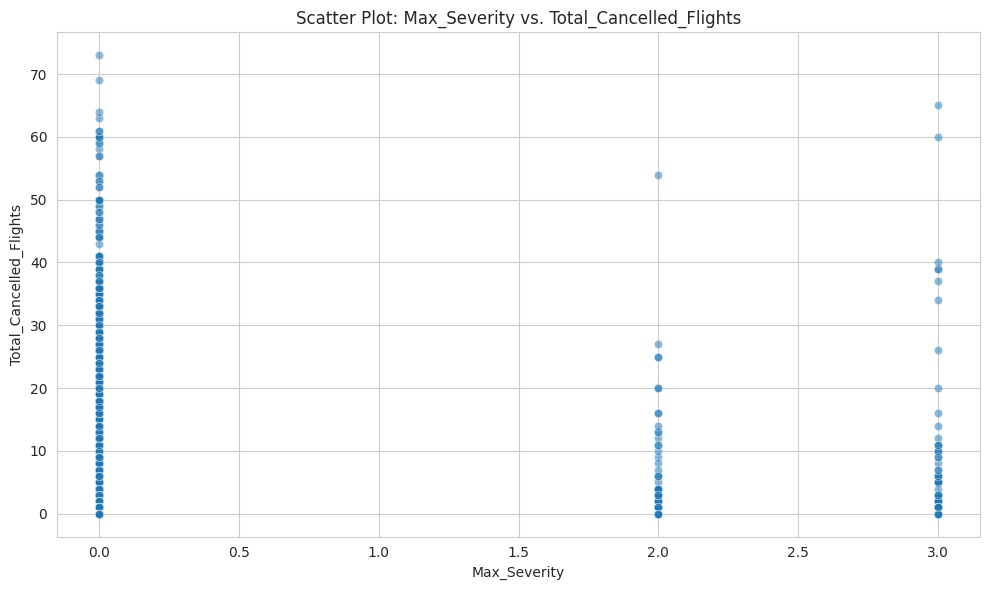

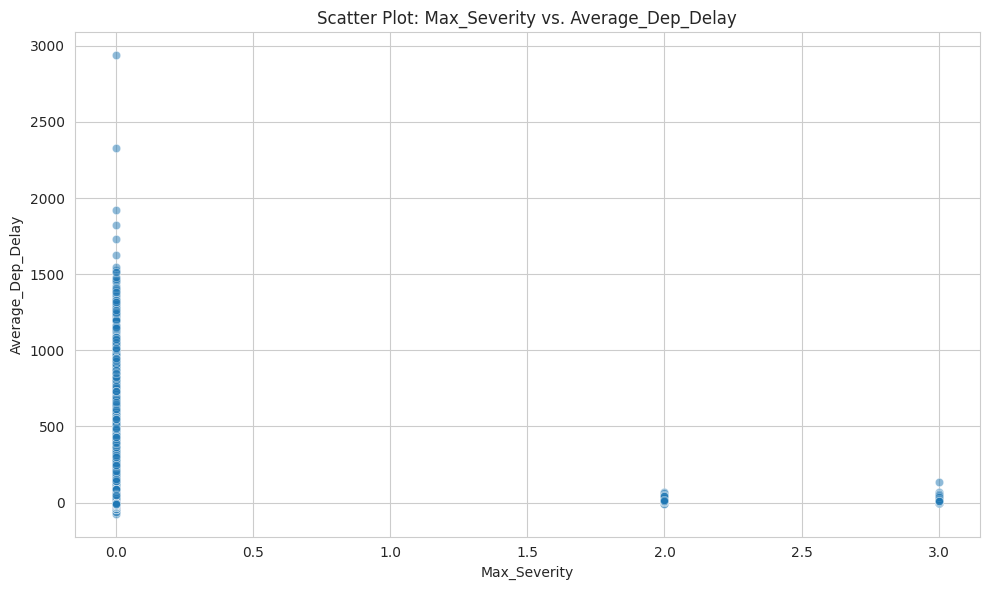

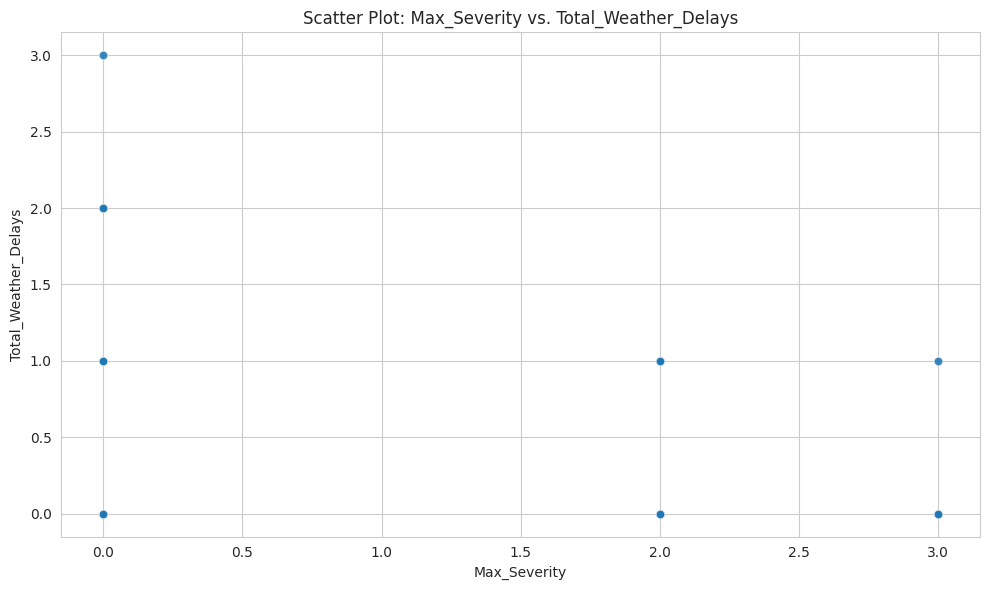

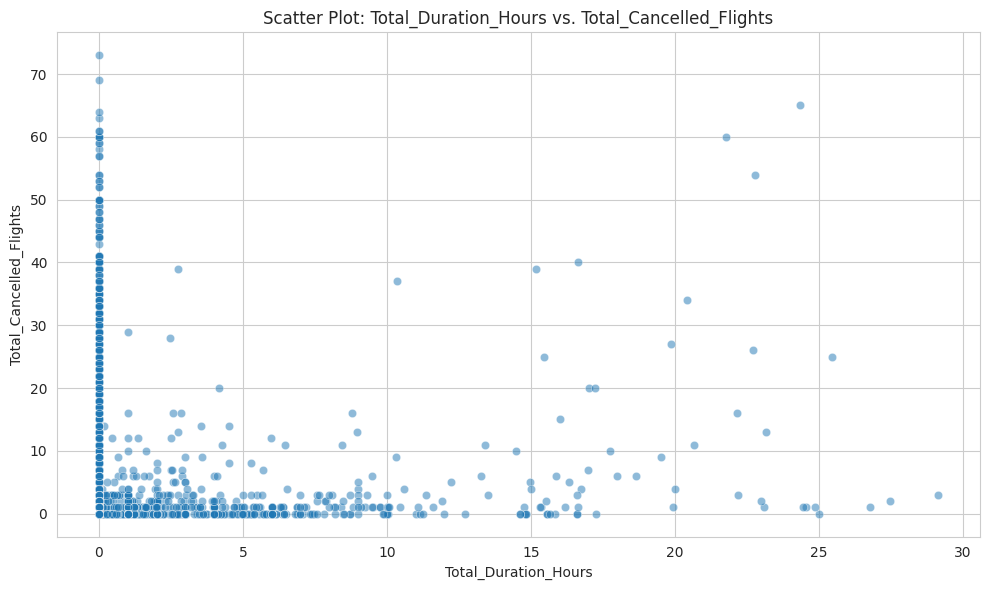

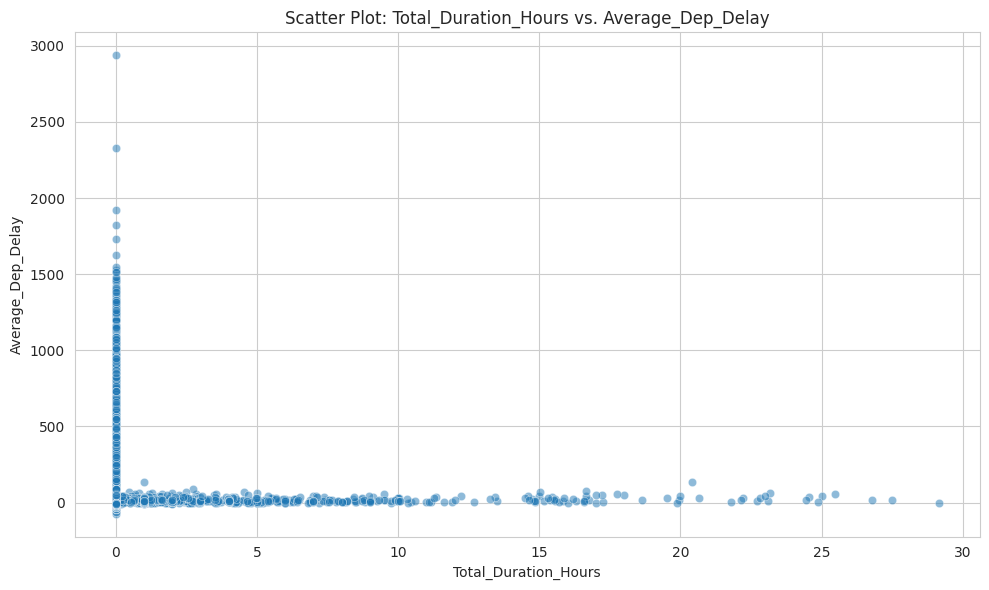

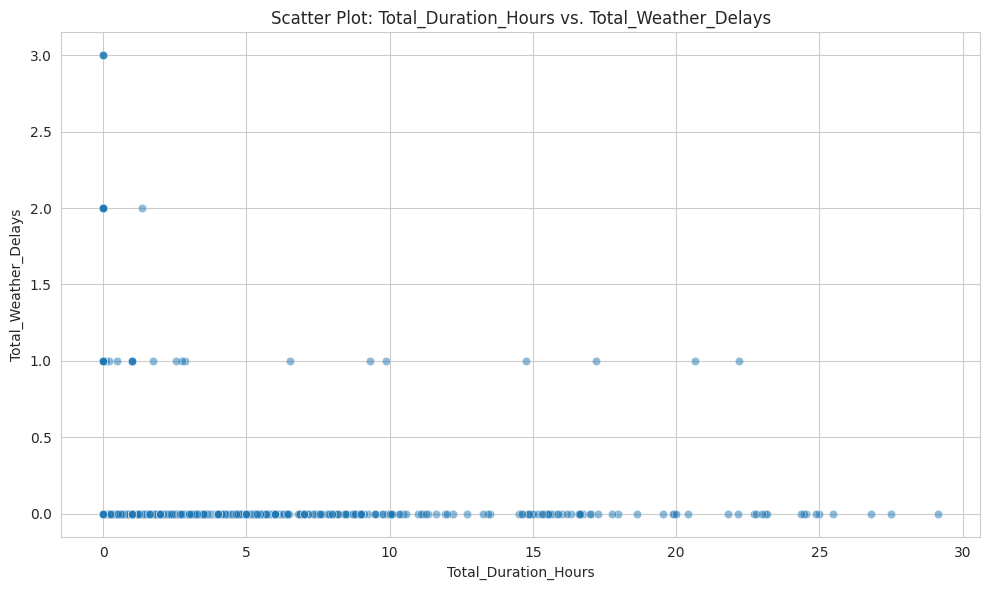

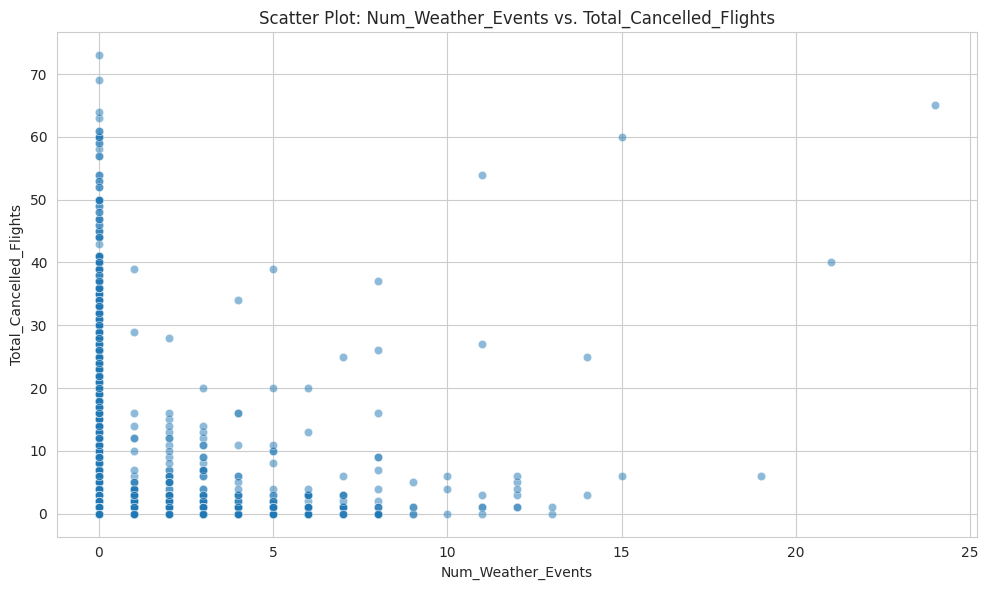

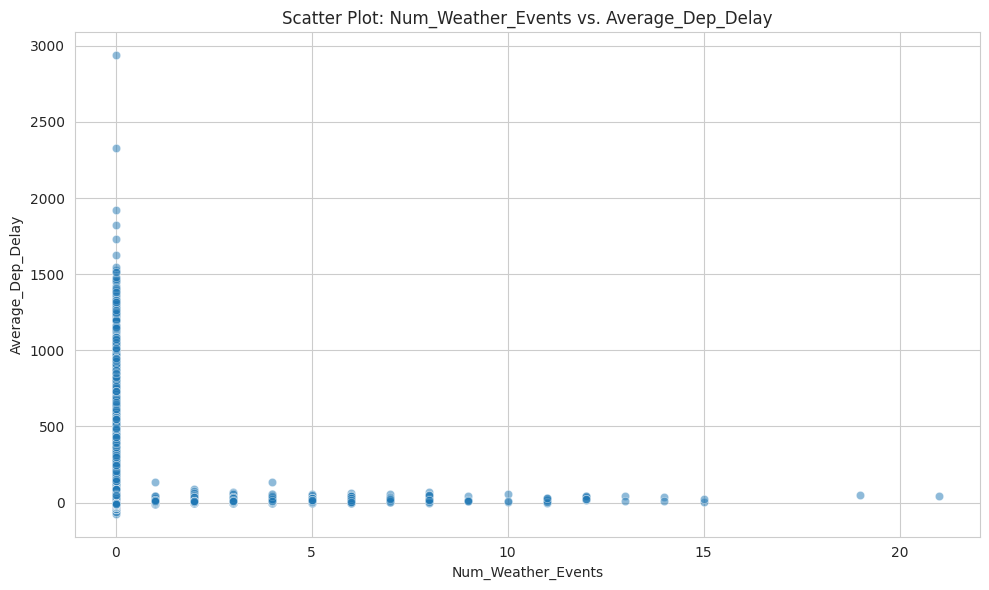

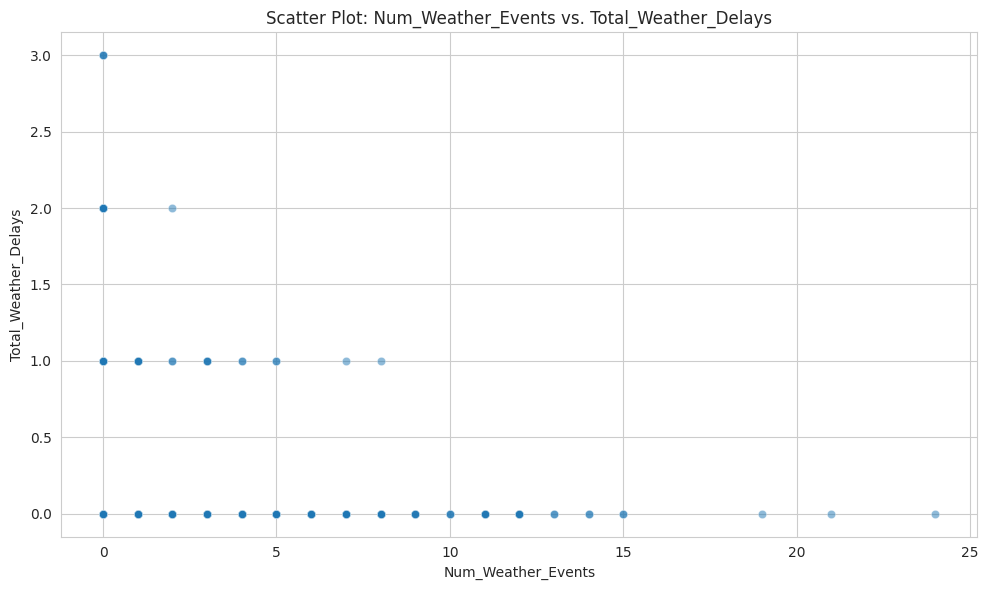


Generating box plots...


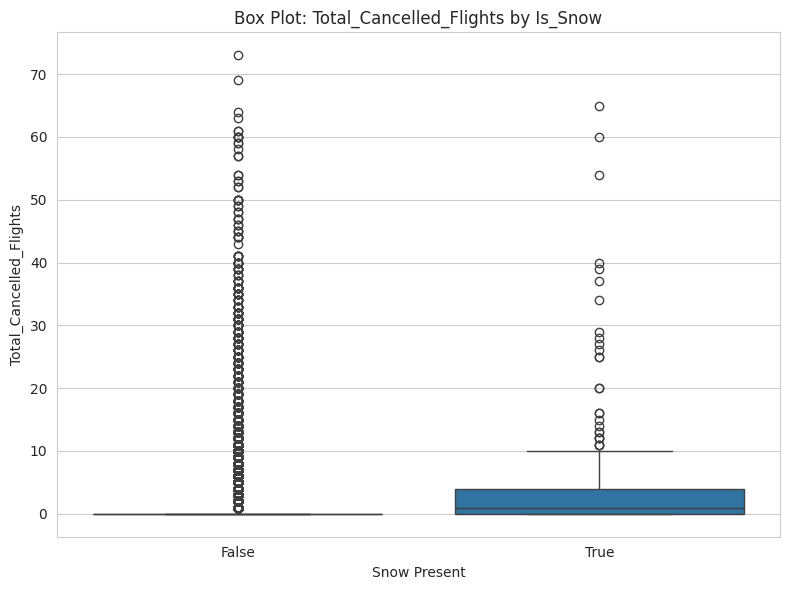

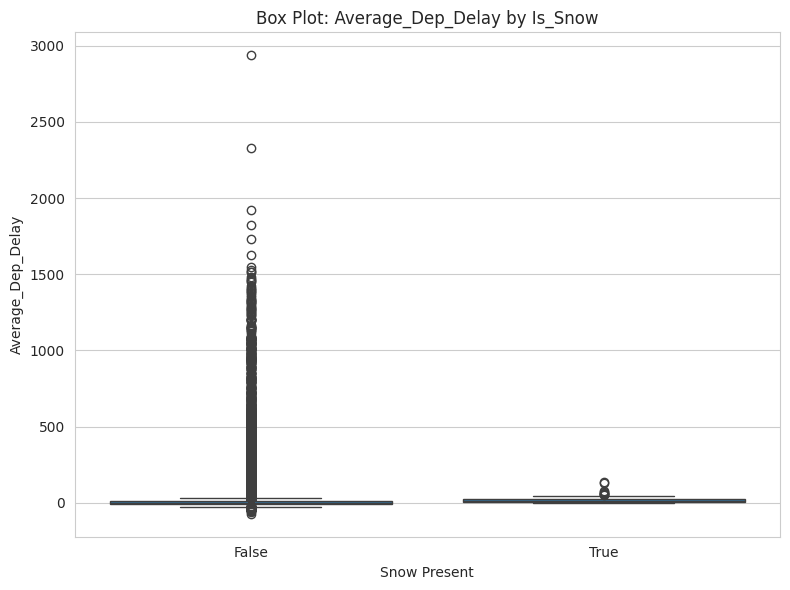

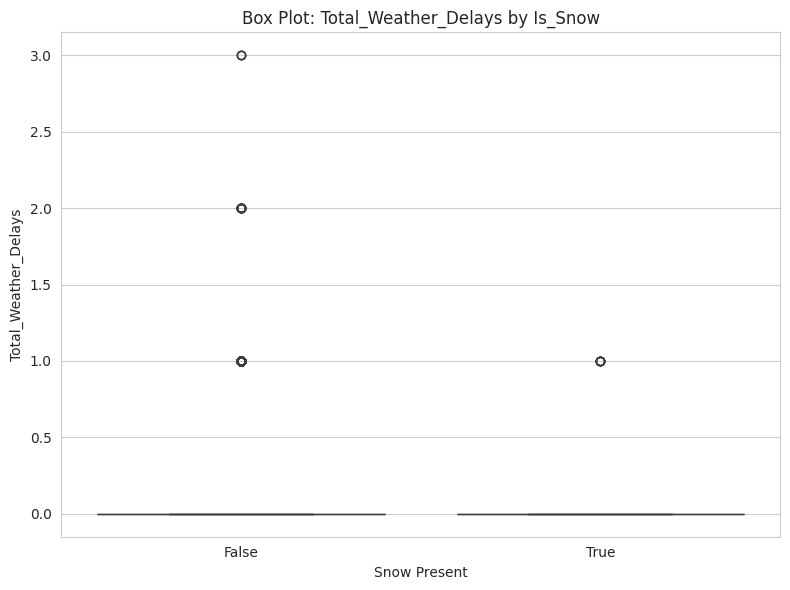

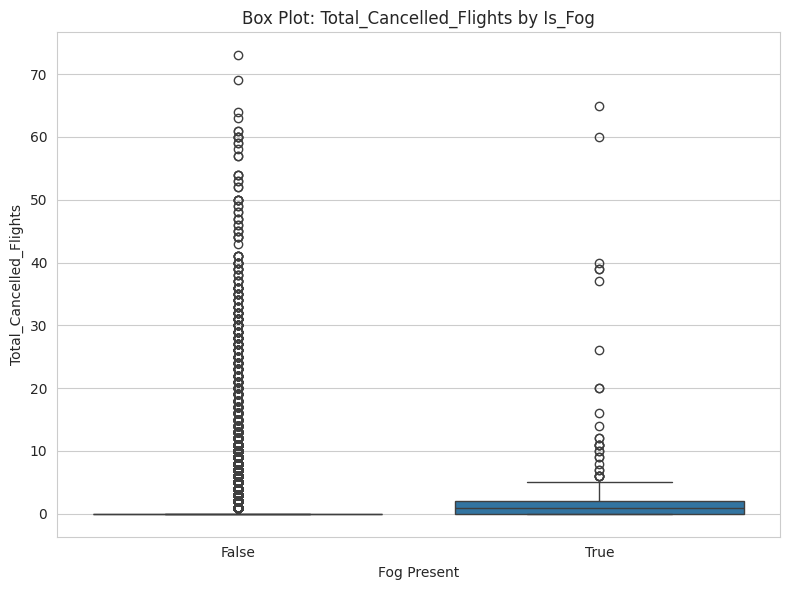

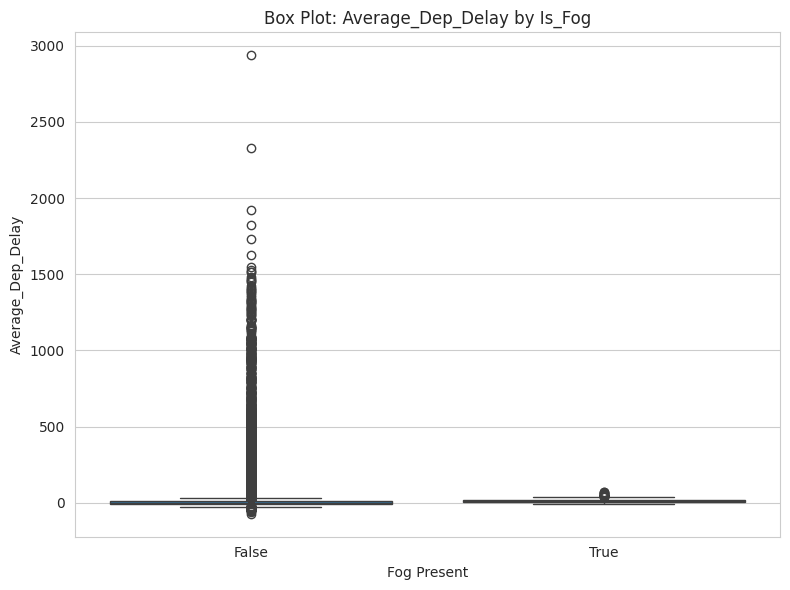

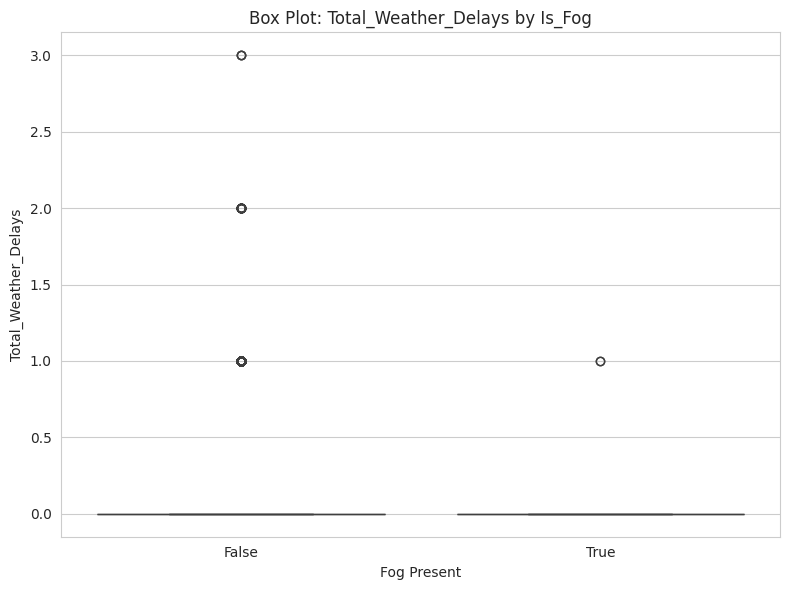

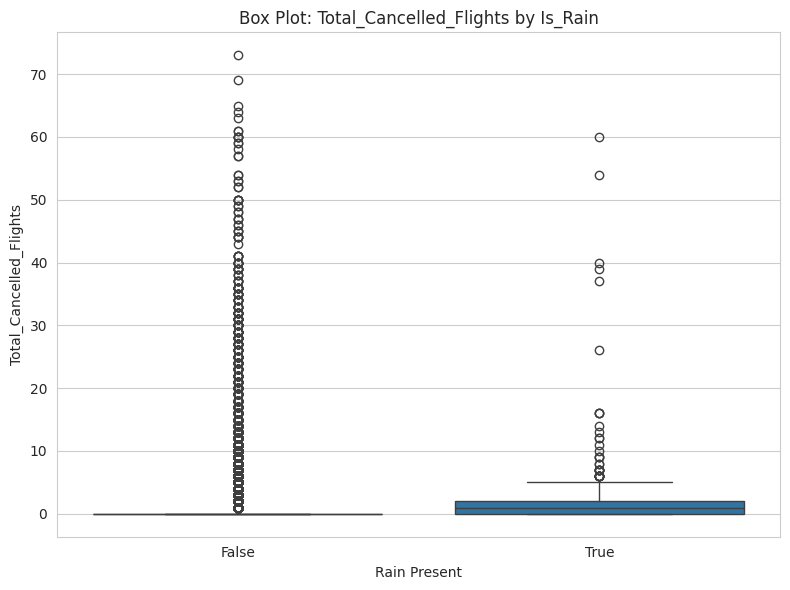

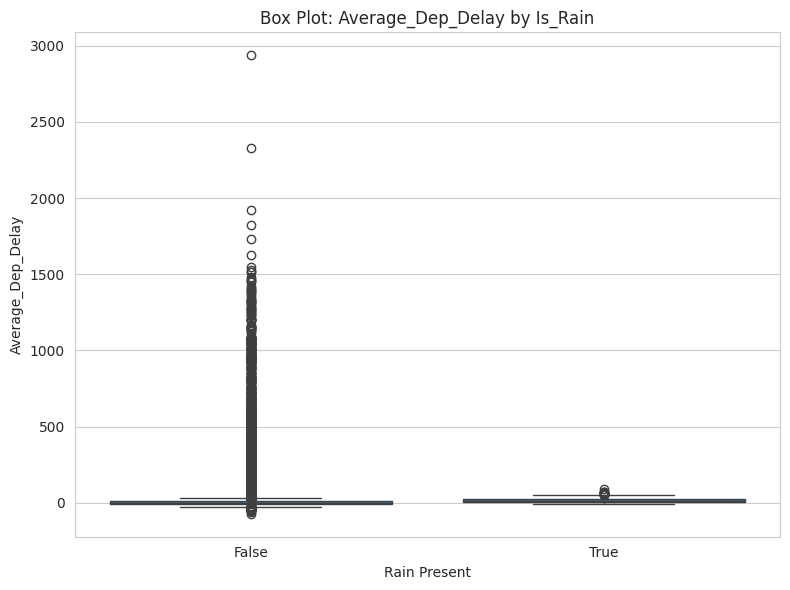

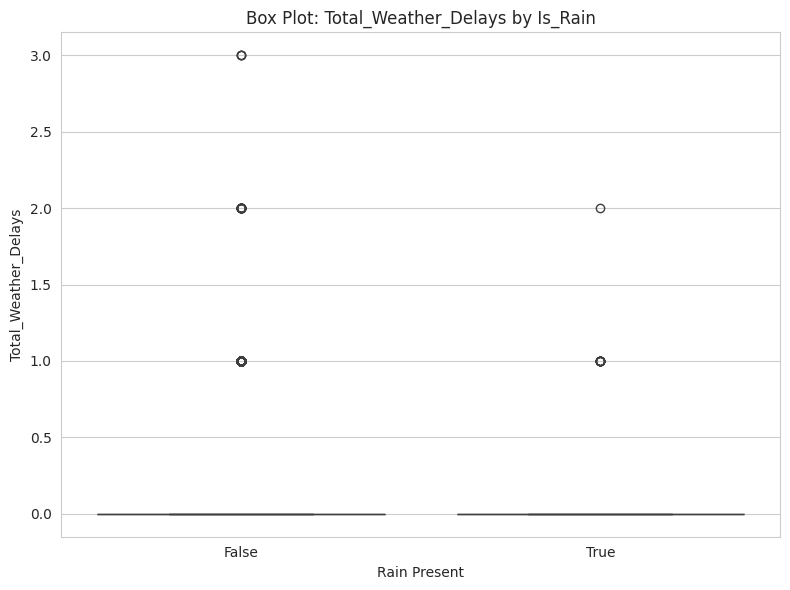

Visualization generation complete.


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Set a suitable plotting style
sns.set_style("whitegrid")

# Define numerical and boolean weather features for plotting
numerical_weather_features = ['Max_Severity', 'Total_Duration_Hours', 'Num_Weather_Events']
boolean_weather_flags = ['Is_Snow', 'Is_Fog', 'Is_Rain']

# Flight performance metrics
flight_metrics = [
    'Total_Cancelled_Flights',
    'Average_Dep_Delay',
    'Total_Weather_Delays'
]

print("Generating scatter plots...")
# 2. Create scatter plots for numerical weather features vs. flight metrics
for weather_feature in numerical_weather_features:
    for flight_metric in flight_metrics:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=correlation_prep_df, x=weather_feature, y=flight_metric, alpha=0.5)
        plt.title(f'Scatter Plot: {weather_feature} vs. {flight_metric}')
        plt.xlabel(weather_feature)
        plt.ylabel(flight_metric)
        plt.tight_layout()
        plt.show()

print("\nGenerating box plots...")
# 3. Create box plots for boolean weather flags vs. flight metrics
for weather_flag in boolean_weather_flags:
    for flight_metric in flight_metrics:
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=correlation_prep_df, x=weather_flag, y=flight_metric)
        plt.title(f'Box Plot: {flight_metric} by {weather_flag}')
        plt.xlabel(weather_flag.replace('Is_', '') + ' Present')
        plt.ylabel(flight_metric)
        plt.tight_layout()
        plt.show()

print("Visualization generation complete.")

## Гипотеза 1

In [22]:
import numpy as np

correlation_prep_df['Max_Severity'] = correlation_prep_df['Max_Severity'].fillna(0).astype(int)

print("Max_Severity column after filling NaNs and converting to int:")
print(correlation_prep_df['Max_Severity'].value_counts())
print(correlation_prep_df['Max_Severity'].head())

Max_Severity column after filling NaNs and converting to int:
Max_Severity
0    337915
3       180
2       169
Name: count, dtype: int64
0    0
1    0
2    0
3    0
4    0
Name: Max_Severity, dtype: int64


In [23]:
import statsmodels.api as sm

# Define flight metrics
flight_metrics = [
    'Total_Cancelled_Flights',
    'Average_Dep_Delay',
    'Total_Weather_Delays'
]

# Get unique severity levels for grouping
severity_levels = sorted(correlation_prep_df['Max_Severity'].unique())

# --- Logistic Regression for Total_Cancelled_Flights ---
print("\n--- Logistic Regression for Cancellation Probability ---")
correlation_prep_df['Has_Cancelled_Flights'] = (correlation_prep_df['Total_Cancelled_Flights'] > 0).astype(int)

log_reg_df = correlation_prep_df.dropna(subset=['Max_Severity', 'Has_Cancelled_Flights']).copy()

X = log_reg_df[['Max_Severity']]
y = log_reg_df['Has_Cancelled_Flights']

# Add a constant to the independent variable for the intercept
X = sm.add_constant(X)

# Fit the logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit(disp=0)

print(result.summary())

# Interpret the coefficient for Max_Severity
print("\nИнтерпретация:")
coeff = result.params['Max_Severity']
p_value = result.pvalues['Max_Severity']
if p_value < 0.05:
    print(f"  Max_Severity has a statistically significant impact on the probability of having cancelled flights (p={p_value:.4f}).")
    odds_ratio = np.exp(coeff)
    print(f"  For every one-unit increase in Max_Severity, the odds of having cancelled flights increase by a factor of {odds_ratio:.2f}.")
else:
    print(f"  Max_Severity does not have a statistically significant impact on the probability of having cancelled flights (p={p_value:.4f}).")



--- ANOVA/Kruskal-Wallis Tests by Max_Severity ---

Analyzing metric: Total_Cancelled_Flights
  Levene's Test for homogeneity of variances (p-value): 0.0000
  Performing Kruskal-Wallis H-test for Total_Cancelled_Flights due to unequal variances.
  Kruskal-Wallis H-test (p-value): 0.0000
  Statistically significant difference in means/medians across Max_Severity levels.

Analyzing metric: Average_Dep_Delay
  Levene's Test for homogeneity of variances (p-value): 0.1584
  Performing One-way ANOVA for Average_Dep_Delay.
  ANOVA F-statistic: 3.60, p-value: 0.0273
  Statistically significant difference in means across Max_Severity levels.

Analyzing metric: Total_Weather_Delays
  Levene's Test for homogeneity of variances (p-value): 0.0000
  Performing Kruskal-Wallis H-test for Total_Weather_Delays due to unequal variances.
  Kruskal-Wallis H-test (p-value): 0.0000
  Statistically significant difference in means/medians across Max_Severity levels.

--- Logistic Regression for Cancellation P

## Гипотеза 2


In [24]:
import scipy.stats as stats
import numpy as np

pd.set_option('future.no_silent_downcasting', True)

# 1. Define the list of boolean weather flags to test
weather_flags_to_test = ['Is_Snow', 'Is_Fog', 'Is_Rain']
weather_flags_to_test = [flag for flag in weather_flags_to_test if flag in correlation_prep_df.columns]

# 2. Define the flight performance metrics to analyze
flight_metrics_to_test = [
    'Total_Cancelled_Flights',
    'Average_Dep_Delay',
    'Total_Weather_Delays'
]

# 3. Iterate through each weather_flag
for weather_flag in weather_flags_to_test:
    print(f"\nAnalyzing impact of {weather_flag.replace('Is_', '')}:\n")

    # 4. For each weather_flag, iterate through each flight_metric
    for flight_metric in flight_metrics_to_test:
        print(f"  Testing {flight_metric}...")

        # a. Divide the correlation_prep_df into two groups
        group_present = correlation_prep_df[correlation_prep_df[weather_flag]][flight_metric].dropna()
        group_absent = correlation_prep_df[~correlation_prep_df[weather_flag]][flight_metric].dropna()

        # b. If both groups contain sufficient data
        if len(group_present) > 1 and len(group_absent) > 1:
            if flight_metric == 'Total_Cancelled_Flights':
                # Use 'Has_Cancelled_Flights' for Chi-squared test
                has_cancelled_present = correlation_prep_df[correlation_prep_df[weather_flag]]['Has_Cancelled_Flights']
                has_cancelled_absent = correlation_prep_df[~correlation_prep_df[weather_flag]]['Has_Cancelled_Flights']

                # Create contingency table
                contingency_table = pd.crosstab(correlation_prep_df[weather_flag], correlation_prep_df['Has_Cancelled_Flights'])
                if contingency_table.shape == (2,2) and contingency_table.sum().sum() > 0:
                    chi2, p_chi2, _, _ = stats.chi2_contingency(contingency_table)
                    print(f"    Chi-squared test for {flight_metric}: chi2={chi2:.2f}, p-value={p_chi2:.4f}")
                    if p_chi2 < 0.05:
                        print(f"    Interpretation: Statistically significant association between {weather_flag.replace('Is_', '')} and cancelled flights.")
                    else:
                        print(f"    Interpretation: No statistically significant association between {weather_flag.replace('Is_', '')} and cancelled flights.")
                else:
                    print(f"    Cannot perform Chi-squared test for {flight_metric}: Contingency table is not valid or has no data.")

            else: # Numerical metrics: Average_Dep_Delay, Total_Weather_Delays
                # Perform Mann-Whitney U test
                stat_mw, p_mw = stats.mannwhitneyu(group_present, group_absent, alternative='two-sided')
                print(f"    Mann-Whitney U test for {flight_metric}: U={stat_mw:.2f}, p-value={p_mw:.4f}")
                if p_mw < 0.05:
                    print(f"    Interpretation: Statistically significant difference in {flight_metric} distributions when {weather_flag.replace('Is_', '')} is present vs. absent.")
                else:
                    print(f"    Interpretation: No statistically significant difference in {flight_metric} distributions when {weather_flag.replace('Is_', '')} is present vs. absent.")
        else:
            print(f"    Not enough data in groups to perform statistical test for {flight_metric}.")

print("\n--- Hypothesis 2 tests complete ---")


--- Statistical Tests for Hypothesis 2 (Weather Type Impact) ---

Analyzing impact of Snow:

  Testing Total_Cancelled_Flights...
    Chi-squared test for Total_Cancelled_Flights: chi2=515.06, p-value=0.0000
    Interpretation: Statistically significant association between Snow and cancelled flights.
  Testing Average_Dep_Delay...
    Mann-Whitney U test for Average_Dep_Delay: U=49324347.00, p-value=0.0000
    Interpretation: Statistically significant difference in Average_Dep_Delay distributions when Snow is present vs. absent.
  Testing Total_Weather_Delays...
    Mann-Whitney U test for Total_Weather_Delays: U=33757048.00, p-value=0.0000
    Interpretation: Statistically significant difference in Total_Weather_Delays distributions when Snow is present vs. absent.

Analyzing impact of Fog:

  Testing Total_Cancelled_Flights...
    Chi-squared test for Total_Cancelled_Flights: chi2=431.07, p-value=0.0000
    Interpretation: Statistically significant association between Fog and cancel

## Гипотеза 3

In [25]:
import pandas as pd
import statsmodels.api as sm

# Define numerical weather feature and flight metrics
weather_duration_feature = 'Total_Duration_Hours'
flight_metrics = [
    'Total_Cancelled_Flights',
    'Average_Dep_Delay',
    'Total_Weather_Delays'
]

# 1. Calculate Pearson correlation coefficients
print(f"\nPearson Correlation with '{weather_duration_feature}':")
for metric in flight_metrics:
    correlation = correlation_prep_df[weather_duration_feature].corr(correlation_prep_df[metric], method='pearson')
    print(f"  {weather_duration_feature} vs. {metric}: {correlation:.4f}")

# 3. and 4. Perform simple linear regression and print model summary
print("\n--- Linear Regression Analysis ---")
for metric in flight_metrics:
    print(f"\nAnalyzing {metric} as dependent variable with {weather_duration_feature} as independent variable:")

    # Prepare data, dropping NaNs for this specific regression to ensure valid calculations
    # The correlation_prep_df already has NaNs filled for relevant columns, so dropping here might remove rows with NaNs in other columns, but not in these specifically.
    # Ensure only necessary columns are used for OLS to avoid issues with non-numeric types
    reg_df = correlation_prep_df[[weather_duration_feature, metric]].dropna()

    if reg_df.empty:
        print(f"  Not enough data to perform regression for {metric}.")
        continue

    X = reg_df[weather_duration_feature]
    y = reg_df[metric]

    # Add a constant to the independent variable for the intercept
    X = sm.add_constant(X)

    # Fit the OLS model
    model = sm.OLS(y, X)
    results = model.fit()

    # 5. Interpret the coefficient for 'Total_Duration_Hours'
    print("\nInterpretation of Regression:")
    coeff = results.params[weather_duration_feature]
    p_value = results.pvalues[weather_duration_feature]

    interpretation = f"  For {weather_duration_feature}, the coefficient is {coeff:.4f} (p-value: {p_value:.4f}). "
    if p_value < 0.05:
        interpretation += "This indicates a statistically significant relationship. "
        if coeff > 0:
            interpretation += f"A one-unit increase in {weather_duration_feature} is associated with an increase of {coeff:.4f} in {metric}."
        else:
            interpretation += f"A one-unit increase in {weather_duration_feature} is associated with a decrease of {abs(coeff):.4f} in {metric}."
    else:
        interpretation += "This relationship is not statistically significant."
    print(interpretation)

print("\n--- Hypothesis 3 tests complete ---")


--- Testing Hypothesis 3 (Duration Impact) ---

Pearson Correlation with 'Total_Duration_Hours':
  Total_Duration_Hours vs. Total_Cancelled_Flights: 0.1025
  Total_Duration_Hours vs. Average_Dep_Delay: 0.0067
  Total_Duration_Hours vs. Total_Weather_Delays: 0.0247

--- Linear Regression Analysis ---

Analyzing Total_Cancelled_Flights as dependent variable with Total_Duration_Hours as independent variable:
                               OLS Regression Results                              
Dep. Variable:     Total_Cancelled_Flights   R-squared:                       0.011
Model:                                 OLS   Adj. R-squared:                  0.010
Method:                      Least Squares   F-statistic:                     3590.
Date:                     Sun, 14 Dec 2025   Prob (F-statistic):               0.00
Time:                             14:53:24   Log-Likelihood:            -5.9300e+05
No. Observations:                   338264   AIC:                         1.186e+06
Df